Solving a simple PDE with the PINN-approach
===========================================
Here we give a beginner-friendly introduction to TorchPhysics, going over all the basic concepts and steps. For a more in-depth explanation, we recommend the [tutorial page](https://torchphysics.readthedocs.io/en/latest/tutorial/tutorial_start.html).
We introduce the library with the aim to solve the following PDE:

\begin{align*}
-\Delta u &= 4.25\pi^2 u \text{ in } \Omega = [0, 1] \times [0, 1] \\
u &= \sin(\tfrac{\pi}{2} x_1)\cos(2\pi x_2) \text{ on } \partial \Omega
\end{align*}

For comparison, the analytic solution is $u(x_1, x_2) = \sin(\tfrac{\pi}{2} x_1)\cos(2\pi x_2)$.

Generally, the first step is to define all appearing variables and giving them a *name*. In TorchPhysics all input variables are considered as variables that have to be named, but also the solution functions. 
From a mathematical point of view we essentially define to what ``space`` these variables *belong* (for example $x \in \mathbb{R}^2$). From a more applied point, we just set the name and dimension of our input and output values:

In [1]:
import torchphysics as tp 
X = tp.spaces.R2('x') # input is 2D and named x
U = tp.spaces.R1('u') # output is 1D and named u

Next up is the domain, in our case a simple square. There are a lot of different domains provided in TorchPhysics (even logical operations and time dependencies are possible), these will be introduced further later in the tutorial and can be found under the section ``domains``. 

Usually a domain gets as an input the space it belongs to (here our 'x') and some different parameters that depend on the constructed object. For a parallelogram, for example the origin and two corners.

In [2]:
square = tp.domains.Parallelogram(X, [0, 0], [1, 0], [0, 1])

Now we define our neural network, that we want to train. There are different architectures pre implemented, but since we build upon PyTorch one can easily define custom networks and use them.

For this example we use a simple fully connected network. In TorchPhysics all classes that handle the networks are collected under the ``models`` section.

In [3]:
model = tp.models.FCN(input_space=X, output_space=U, hidden=(50,50,50,50,50))

The next step is the definition of the training conditions. Here we transform our PDE into some residuals that we minimize in the training. From an implementation point, we stay close to the original (mathematical) PDE and to the standard PINN approach.

Here we have two different conditions that the network should fulfill, the differential
equation itself and the boundary condition. Here, we start with the boundary condition:

  - For this, one has to first define a Python-function, that describes our trainings condition. 
    As an input, one can pick all variables and networks that appear in the problem and were defined 
    previously, via the ``spaces``. The output should describe how well the considered condition is fulfilled. 
    In our example, we just compute the expected boundary values and return the difference to the current network output. Here, ``u`` will already be the network evaluated at the points ``x`` (a batch of coordinates). Internally, this will then be transformed automatically to an MSE-loss (which can also be customized, if needed).
  - We also need to tell on which points this condition should be fulfilled. For this TorchPhysics provides
    the ``samplers`` section. Where different sampling strategies are implemented. 
    For the boundary condition we only need points at the boundary, in TorchPhysics all domains have the property ``.boundary`` that returns the boundary as a new domain-object. 

In [4]:
import torch
import numpy as np
# Frist the function that defines the residual:
def bound_residual(u, x):
    bound_values = torch.sin(np.pi/2*x[:, :1]) * torch.cos(2*np.pi*x[:, 1:])
    return u - bound_values

# the point sampler:
# here we use 5000 grid points any other sampler could also be used
bound_sampler = tp.samplers.GridSampler(square.boundary, n_points=5000)
bound_sampler = bound_sampler.make_static() # grid always the same, therfore static for one single computation

Once all this is defined, we have to combine the residual and sampler in a ``condition``. These condition handle internally the training process. Under the hood, they have the following simplified behavior (while training):

 1) Sample points with the given sampler
 2) Evaluate model at these points
 3) Plug points and model output into the given residual 
 4) Compute corresponding loss term
 5) Pass loss to the optimizer

In TorchPhysics many different condition types are pre implemented (for including data, integral conditions, etc.). Here we use the PINN approach, which corresponds to a ``PINNCondition``:

In [5]:
bound_cond = tp.conditions.PINNCondition(module=model, sampler=bound_sampler, 
                                         residual_fn=bound_residual, weight=10)

The same holds for the differential equation term. Here also different operators are implemented, that help to compute the derivatives of the neural network. They can be found under the ``utils`` section. 

In [6]:
# Again a function that defines the residual:
def pde_residual(u, x):
    return tp.utils.laplacian(u, x) + 4.25*np.pi**2*u

# the point sampler, for the trainig points:
pde_sampler = tp.samplers.RandomUniformSampler(square, n_points=15000) 
# random points will be resampled in each iteration!

# wrap everything together in the condition
pde_cond = tp.conditions.PINNCondition(module=model, sampler=pde_sampler, 
                                       residual_fn=pde_residual)

The transformation of our PDE into a TorchPhysics problem is finished. So we can start the
training.

The last step before the training is the creation of a ``Solver``. This is an object that inherits from
the Pytorch Lightning *LightningModule*. It handles the training and validation loops and takes care of the
data loading for GPUs or CPUs. It gets the following inputs:

- train_conditions: A list of all train conditions
- val_conditions: A list of all validation conditions (optional)
- optimizer_setting: With this, one can specify what optimizers, learning, and learning-schedulers 
  should be used. For this, there exists the class *OptimizerSetting* that handles all these parameters.

In [7]:
# here we start with Adam:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001)

solver = tp.solver.Solver(train_conditions=[bound_cond, pde_cond], optimizer_setting=optim)

Now we define the trainer, for this we use Pytorch Lightning. Almost all functionalities of
Pytorch Lightning can be applied in the trainings process.

In [8]:
import pytorch_lightning as pl
## maybe selcet the GPU to use:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

trainer = pl.Trainer(gpus=1, # or None if CPU is used
                     max_steps=4000, # number of training steps
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
                     
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 10.4 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
10.4 K    Trainable params
0         Non-trainable params
10.4 K    Total params
0.042     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Afterwards we switch to LBFGS:

In [9]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.LBFGS, lr=0.05, 
                            optimizer_args={'max_iter': 2, 'history_size': 100})

pde_cond.sampler = pde_cond.sampler.make_static() # LBFGS can not work with varing points!
solver = tp.solver.Solver(train_conditions=[bound_cond, pde_cond], optimizer_setting=optim)

trainer = pl.Trainer(gpus=1,
                     max_steps=3000, # number of training steps
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
                     
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 10.4 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
10.4 K    Trainable params
0         Non-trainable params
10.4 K    Total params
0.042     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

If we want to have a look on our solution, we can use the plot-methods of TorchPhysics:

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/tomfre/Desktop/torchphysics/src/torchphysics/problem/domains/domain2D/parallelogram.py:134: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2985.)
  bary_coords = torch.stack(torch.meshgrid((x, y))).T.reshape(-1, 2)
/home/tomfre/Desktop/torchphysics/src/torchphysics/utils/plotting/plot_functions.py:416: UserWarning: Creating a tensor from a list of 

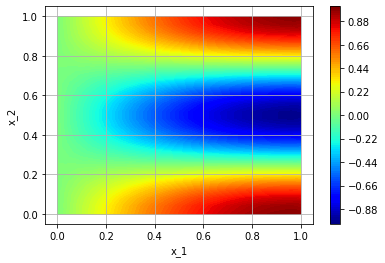

In [10]:
plot_sampler = tp.samplers.PlotSampler(plot_domain=square, n_points=640, device='cuda')
fig = tp.utils.plot(model, lambda u : u, plot_sampler, plot_type='contour_surface')

We can also plot the error, since we know the exact solution:

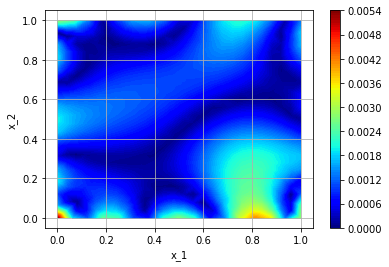

In [11]:
def plot_fn(u, x):
    exact = torch.sin(np.pi/2*x[:, :1])*torch.cos(2*np.pi*x[:, 1:])
    return torch.abs(u - exact)
fig = tp.utils.plot(model, plot_fn, plot_sampler, plot_type='contour_surface')

Now you saw the basics on solbing a PDE in TorchPhysics, additional examples can 
be found under the [example-folder](https://github.com/boschresearch/torchphysics/tree/main/examples).

More in-depth information can be found in the [tutorial](https://torchphysics.readthedocs.io/en/latest/tutorial/tutorial_start.html).